In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from autogluon.timeseries import TimeSeriesDataFrame
import pandas as pd
import numpy as np
import joblib

from src.predictors.chronos import Chronos
from autogluon.timeseries import TimeSeriesPredictor

/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# read in "realistierter Stromverbrauch" 
df = pd.read_csv("data/Realisierter_Stromverbrauch_202103010000_202503270000_Stunde.csv", sep=";", decimal=",", thousands=".", parse_dates=["Datum von", "Datum bis"], na_values=["-"], dayfirst=True)
df = df[["Datum von", "Netzlast [MWh] Berechnete Auflösungen", "Residuallast [MWh] Berechnete Auflösungen"]].copy()
df = df.rename(columns={"Datum von":"timestamp"})
df = df.drop_duplicates(subset=["timestamp"], keep="first")
df = df.melt(id_vars="timestamp", var_name="item_id", value_name="target")
# encode item id
df["item_id"], mapping  = pd.factorize(df["item_id"])
mapping = {i: m for i, m in zip(range(0, len(mapping)), mapping)}

In [3]:
# alternatively could also read in Großhandelspreise from 2015-2025
df_1 = pd.read_csv("data/Gro_handelspreise_201501010000_202101010000_Stunde.csv", sep=";", decimal=",", thousands=".", parse_dates=["Datum von", "Datum bis"], na_values=["-"], dayfirst=True)
df_2 = pd.read_csv("data/Gro_handelspreise_202001010000_202504060000_Stunde.csv", sep=";", decimal=",", thousands=".", parse_dates=["Datum von", "Datum bis"], na_values=["-"], dayfirst=True)
df = pd.concat([df_1, df_2])
df = df.rename(columns={"Datum von":"timestamp"})
df = df.drop(columns="Datum bis")
df = df.drop_duplicates(subset=["timestamp"], keep="first")
# unpivot data frame
df = df.melt(id_vars="timestamp", var_name="item_id", value_name="target")
# encode item id
df["item_id"], mapping  = pd.factorize(df["item_id"])
mapping = {i: m for i, m in zip(range(0, len(mapping)), mapping)}

In [4]:
# mapping of item ids to time series
mapping

{0: 'Deutschland/Luxemburg [€/MWh] Originalauflösungen',
 1: '∅ Anrainer DE/LU [€/MWh] Originalauflösungen',
 2: 'Belgien [€/MWh] Originalauflösungen',
 3: 'Dänemark 1 [€/MWh] Originalauflösungen',
 4: 'Dänemark 2 [€/MWh] Originalauflösungen',
 5: 'Frankreich [€/MWh] Originalauflösungen',
 6: 'Niederlande [€/MWh] Originalauflösungen',
 7: 'Norwegen 2 [€/MWh] Originalauflösungen',
 8: 'Österreich [€/MWh] Originalauflösungen',
 9: 'Polen [€/MWh] Originalauflösungen',
 10: 'Schweden 4 [€/MWh] Originalauflösungen',
 11: 'Schweiz [€/MWh] Originalauflösungen',
 12: 'Tschechien [€/MWh] Originalauflösungen',
 13: 'DE/AT/LU [€/MWh] Originalauflösungen',
 14: 'Italien (Nord) [€/MWh] Berechnete Auflösungen',
 15: 'Slowenien [€/MWh] Originalauflösungen',
 16: 'Ungarn [€/MWh] Originalauflösungen'}

In [5]:
df["target"]

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
1528992   NaN
1528993   NaN
1528994   NaN
1528995   NaN
1528996   NaN
Name: target, Length: 1528997, dtype: float64

In [4]:
# create TimesSeriesDataFrame for convenience
data = TimeSeriesDataFrame(df)
data_train, data_test = data.split_by_time(pd.Timestamp("01-01-2023"))

# Predictions

### Chronos Bolt Zero Shot

In [24]:
chronos = Chronos(model_name="amazon/chronos-bolt-tiny",
                  device_map="mps",
                  lead_times=[1,4,8,12,24,36,48,60],
                  freq=pd.Timedelta("1h"))

# get zero shot perdictions on test dataset
predictions_raw = chronos.predict(data=data_test,
                                  previous_context_data=data_train)


Load chronos pipeline.


Predicting: 100%|██████████| 5809/5809 [04:04<00:00, 23.75it/s]


In [ ]:
# get zero shot predictions on training dataset - used for postprocessing later
predictions_train = chronos.predict(data=data_train,
                                    previous_context_data=None)


In [25]:
predictions_raw.get_crps(mean_time=True, mean_lead_times=True)

,Mean CRPS
mean,14.68


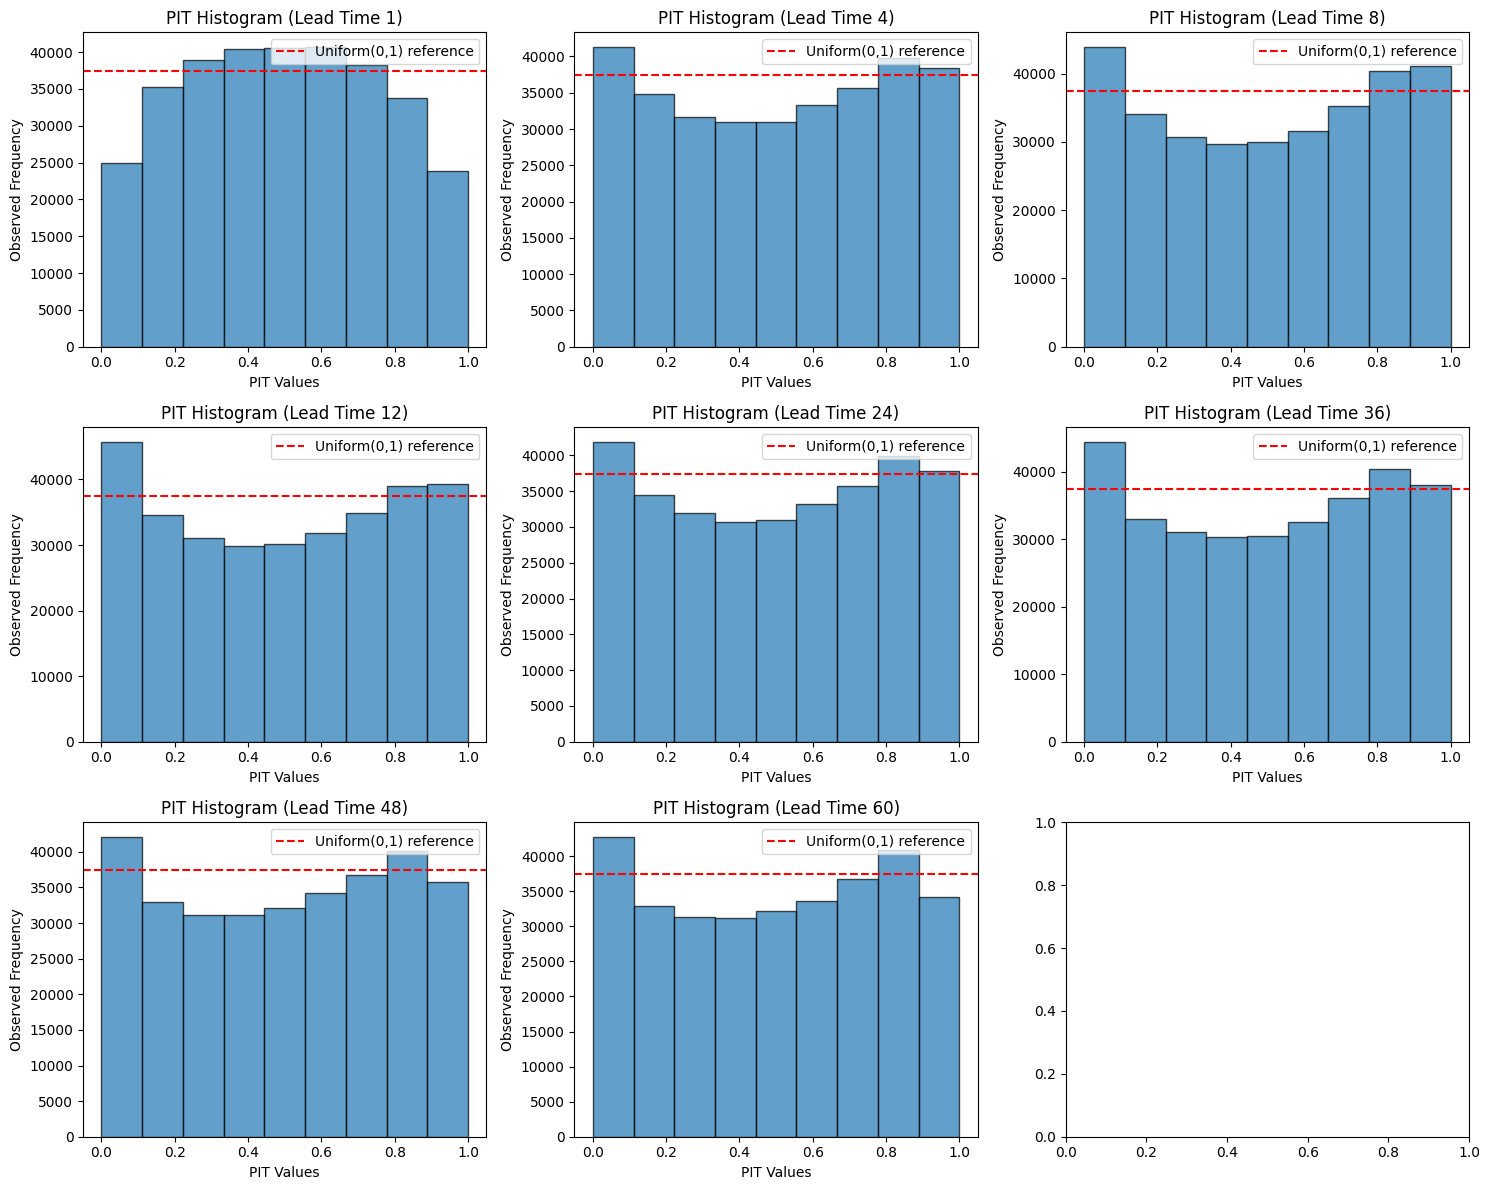

In [26]:
predictions_raw.get_pit_histogram()

In [66]:
predictions_raw.get_crps(mean_time=True, mean_lead_times=True)

,Mean CRPS
mean,3739.01


In [27]:
joblib.dump(predictions_raw.results, "data/predictions/großhandelspreise/predictions_raw.joblib")

['data/predictions/großhandelspreise/predictions_raw.joblib']

# Chronos bolt finetuning - via Autogluon Framework

In [79]:
# fine tune using autogluon
predictor = TimeSeriesPredictor(prediction_length=64, freq="1h").fit(
    train_data=data_train,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_tiny", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}, "device": "mps"},
        ]
    },
    time_limit=120,  # time limit in seconds
    enable_ensemble=False,
)

Frequency '1h' stored as 'h'
Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to '/Users/louisskowronek/Documents/thesis/master-thesis/AutogluonModels/ag-20250422_185624'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.6.0: Thu Dec 19 20:47:53 PST 2024; root:xnu-10063.141.1.703.2~1/RELEASE_ARM64_T6030
CPU Count:          12
GPU Count:          0
Memory Avail:       18.73 GB / 36.00 GB (52.0%)
Disk Space Avail:   421.74 GB / 926.35 GB (45.5%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'FineTuned'},
                                  'device': 'mps',
                                  'fine_tune': True,
                                  'model_path': 'bolt_tiny'}]},
 'known_covariates_names': [],
 'num_val_wi

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=True,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.NO,
eval_use

	Saving fine-tuned model to /Users/louisskowronek/Documents/thesis/master-thesis/AutogluonModels/ag-20250422_185624/models/ChronosFineTuned[bolt_tiny]/W0/fine-tuned-ckpt
	-0.6028       = Validation score (-WQL)
	93.47   s     = Training runtime
	0.11    s     = Validation (prediction) runtime
	Can't pickle <class 'autogluon.timeseries.models.chronos.model.ChronosModel'>: it's not the same object as autogluon.timeseries.models.chronos.model.ChronosModel
Training complete. Models trained: []
Total runtime: 93.60 s
Trainer has no fit models that can predict.


In [12]:
chronos = Chronos(model_name="./AutogluonModels/ag-20250421_165204/models/ChronosFineTuned[bolt_tiny]/W0/fine-tuned-ckpt",
                  device_map="mps",
                  lead_times=np.arange(1, 65),
                  freq=pd.Timedelta("1h"))

# get zero shot perdictions on test dataset
predictions_finetuned_autogluon = chronos.predict(data=data_test,
                                  previous_context_data=data_train)

load chronos pipeline


Predicting: 100%|██████████| 676/676 [00:27<00:00, 24.58it/s]


In [13]:
predictions_finetuned_autogluon.get_crps(mean_lead_times=True, mean_time=True)

,Mean CRPS
mean,3728.47


In [279]:
joblib.dump(predictions_raw, "data/predictions/predictions_raw.joblib")

['data/predictions/predictions_raw.joblib']

# Chronos Finetuning - own implementation

- still uses elements from the autogluon library
- allows full fine tuning, last layer finetuning, LoRa parameter efficient finetuning
- hyperparameter tuning with autogluon
- logs results with tensorboard


In [5]:
from pathlib import Path
from src.predictors.chronos import fine_tune, model_init_full_tuning, model_init_last_layer_tuning, model_init_lora

In [6]:
# split train data further into train and validation data
data_chronos_train, data_chronos_val = data_train.split_by_time(pd.Timestamp("01-01-2022"))

In [ ]:
fine_tune(model_init=model_init_full_tuning, 
          data_train=data_chronos_train, 
          data_val=data_chronos_val,
          path=Path("./models/test-full-finetuning/"),
          hp_tuning=False,
          n_trials=10)

In [83]:
fine_tune(model_init=model_init_lora, 
          data_train=data_chronos_train, 
          data_val=data_chronos_val,
          path=Path("./models/test-lora/"),
          hp_tuning=False,
          n_trials=10)

Final training hyperparameters:
--------------------------------------------------
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=True,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,

In [ ]:
chronos = Chronos(model_name="./models/test-lora/fine-tuned-ckpt",
                  device_map="mps",
                  lead_times=np.arange(1, 65),
                  freq=pd.Timedelta("1h"),
                  lora=True)


predictions_lora_finetuned = chronos.predict(data=data_test,
                                  previous_context_data=data_train)

In [74]:
chronos = Chronos(model_name="./models/test-full-finetuning/fine-tuned-ckpt",
                  device_map="mps",
                  lead_times=[1,4,8,12,24,36,48,60],#lead_times=np.arange(1, 65),
                  freq=pd.Timedelta("1h"))

predictions_full_finetuned = chronos.predict(data=data_test,
                                             previous_context_data=data_train)

Load chronos pipeline.


Predicting: 100%|██████████| 5809/5809 [14:29<00:00,  6.68it/s]


In [30]:
predictions_full_finetuned.get_crps(mean_lead_times=True, mean_time=True)

,Mean CRPS
mean,3560.93


In [ ]:
# get fine tuned predictions on training dataset - used for postprocessing
predictions_train = chronos.predict(data=data_train,
                                    previous_context_data=None)

Predicting: 100%|██████████| 676/676 [00:27<00:00, 24.77it/s]


In [75]:
# r=4, alpha=32
predictions_lora_finetuned.get_crps(mean_lead_times=True, mean_time=True)

,Mean CRPS
mean,3682.57


<Figure size 800x800 with 0 Axes>

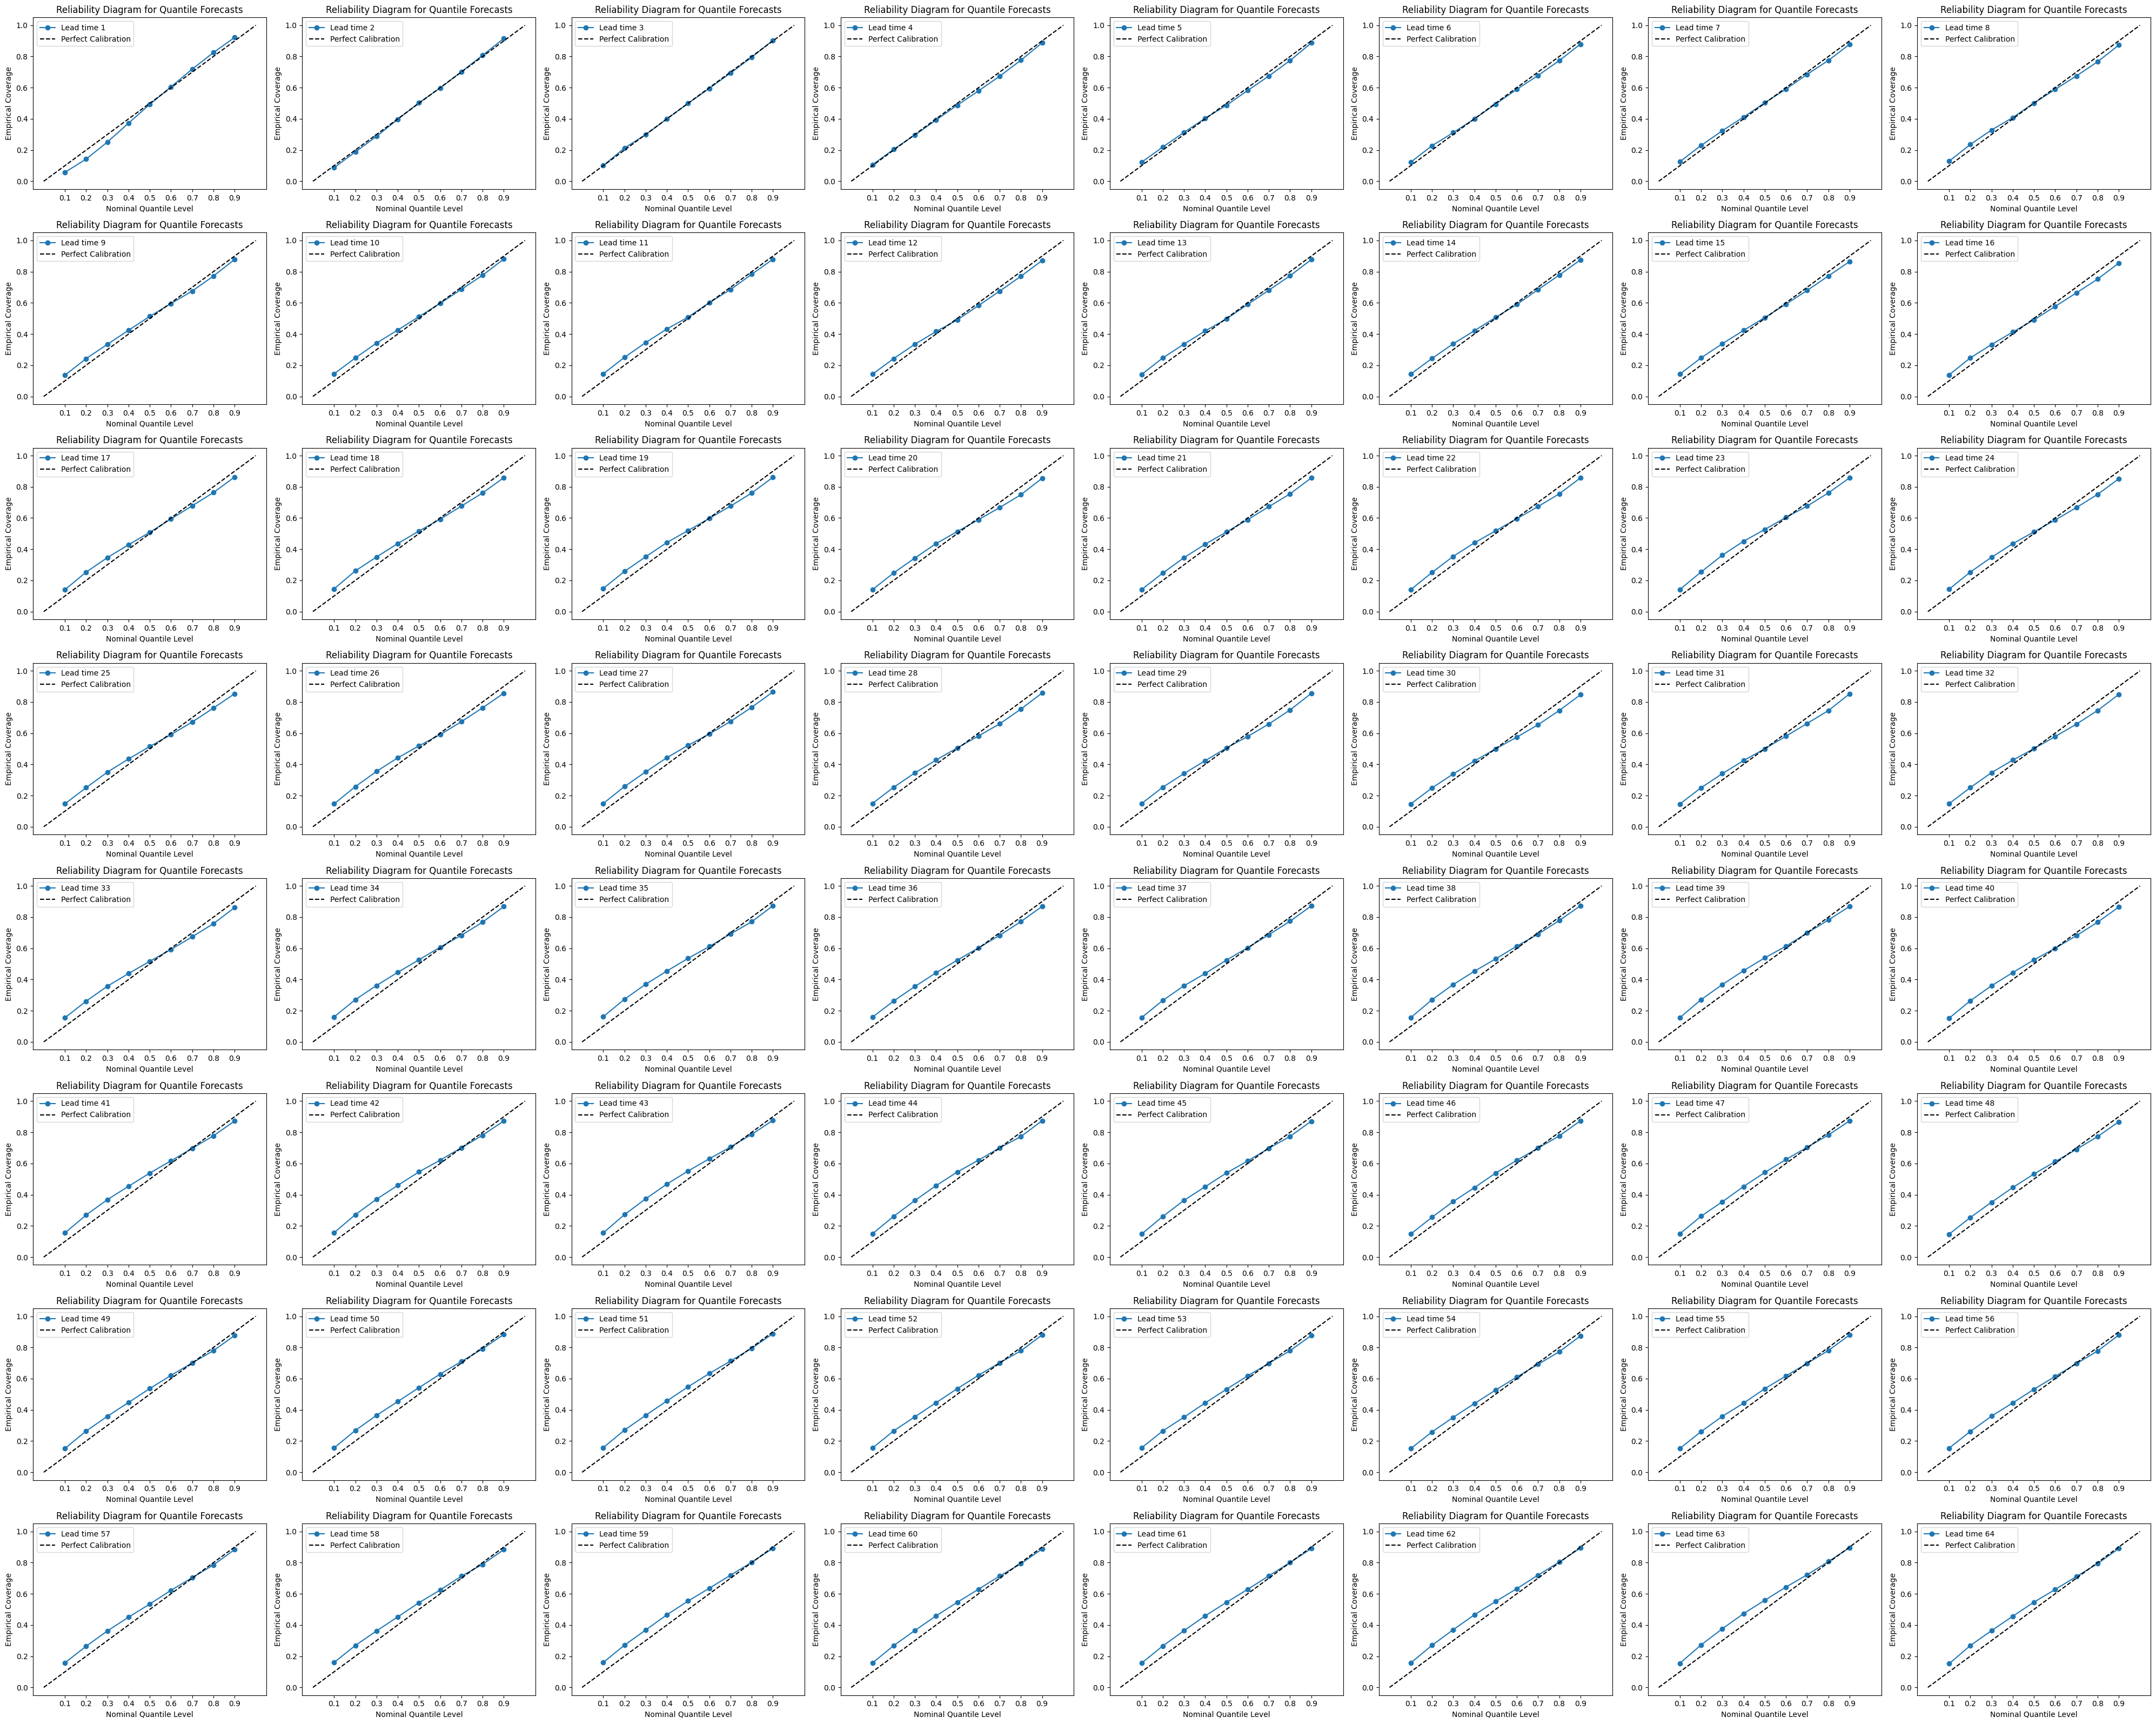

In [76]:
predictions_lora_finetuned.get_reliability_diagram()

In [64]:
# r=2, alpha=4
predictions_lora_finetuned.get_crps(mean_lead_times=True, mean_time=True)

,Mean CRPS
mean,3664.29


In [ ]:
joblib.dump(predictions_finetuned, "data/predictions/predictions_finetuned.joblib")

['data/predictions/predictions_raw.joblib']

### Quantile Regression – Benchmark

- simple quantile regresssion with seasonal variables (only calculated based on time information)

In [119]:
from src.predictors.quantile_regression import QuantileRegression

In [120]:
quantreq = QuantileRegression(quantiles = np.arange(0.1, 1, 0.1),
                              lead_times=np.arange(1, 65),
                              freq=pd.Timedelta("1h"))

quantreq.fit(data_train)
predictions_benchmark_qr = quantreq.predict(data_test)

  6%|▋         | 4/64 [00:41<09:31,  9.52s/it]/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 19%|█▉        | 12/64 [01:51<08:07,  9.38s/it]/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 48%|████▊     | 31/64 [04:23<04:25,  8.04s/it]/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
100%|██████████| 64/64 [00:07<00:00,  

In [126]:
joblib.dump(predictions_benchmark_qr, "data/predictions/predictions_benchmark_qr.joblib")

['data/predictions/predictions_benchmark_qr.joblib']

### Nearest Neigbour Approach - Benchmark
- Berechne empirische Quantile basierend auf den vergangenen Werten des gleichen Wochentags und der gleichen Stunde.

In [28]:
from src.predictors.nearest_neighbour import NNPredictor

In [29]:
nn_predictor = NNPredictor(quantiles = np.arange(0.1, 1, 0.1),
                           lead_times=[1,4,8,12,24,36,48,60],#np.arange(1, 65),
                           freq=pd.Timedelta("1h"))

nn_predictor.fit(data_train)
predictions_benchmark_nn = nn_predictor.predict(data_test)

100%|██████████| 336957/336957 [01:06<00:00, 5097.99it/s]


In [31]:
predictions_benchmark_nn.get_crps(mean_lead_times=True, mean_time=True)

,Mean CRPS
mean,25.98


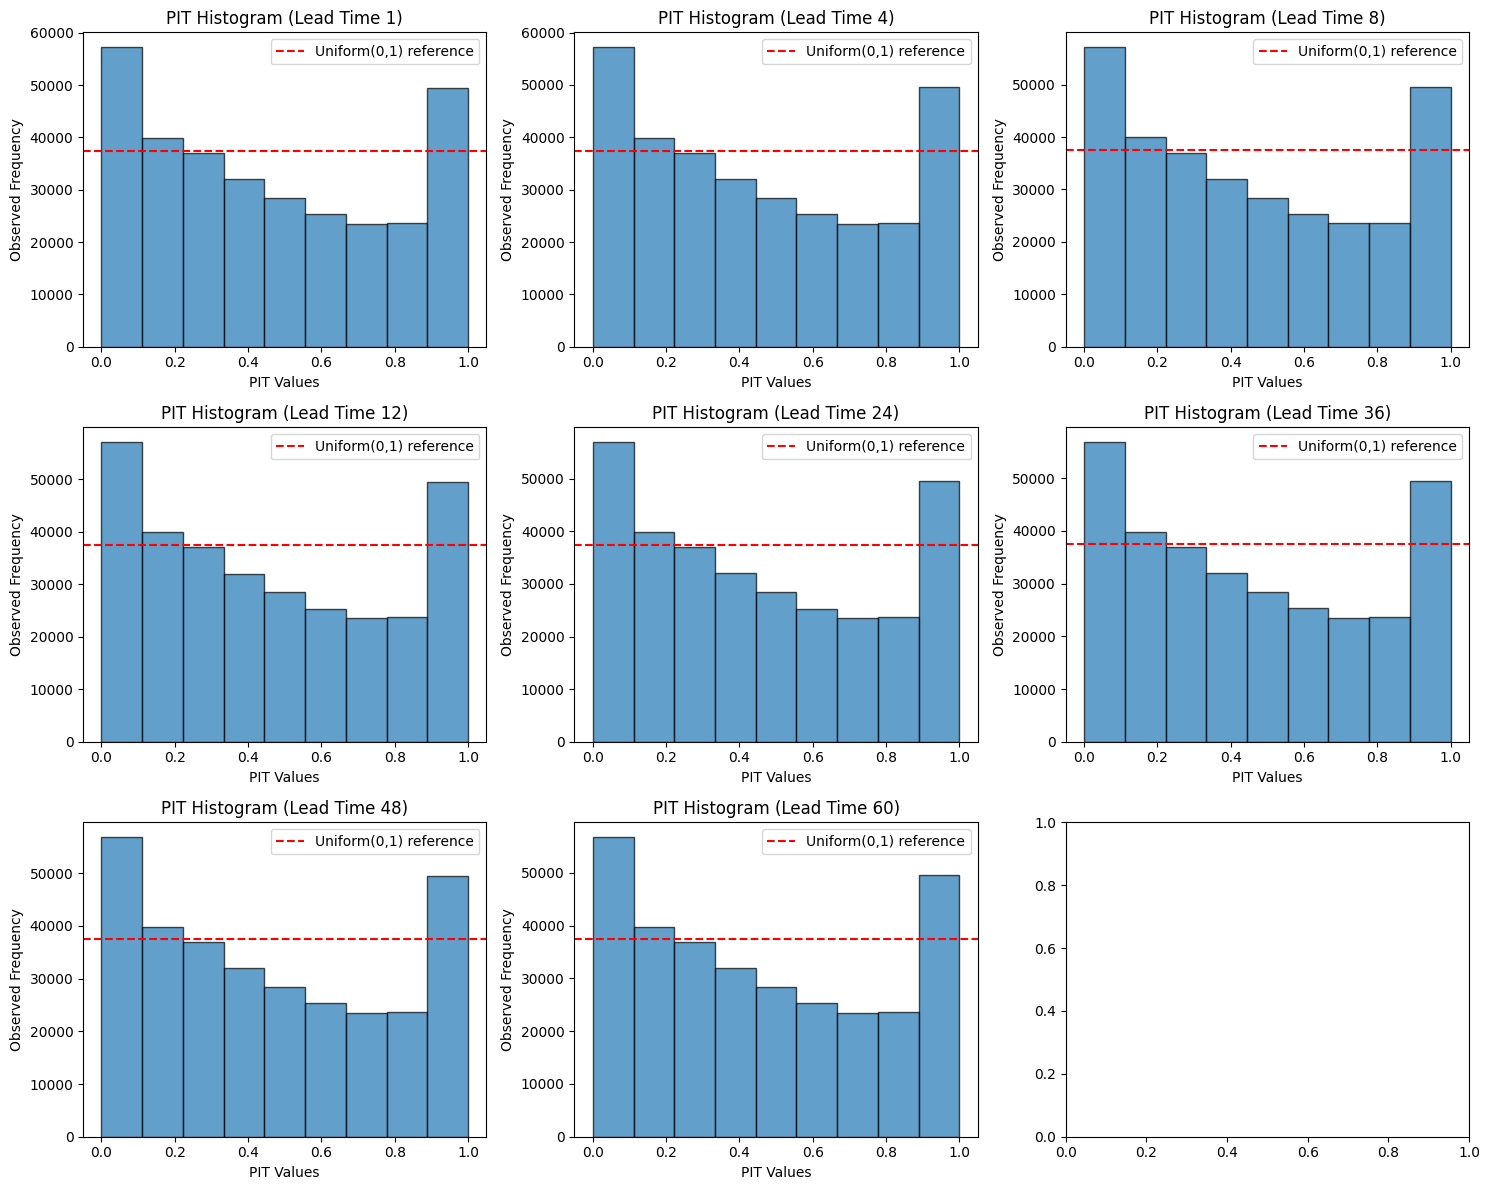

In [33]:
predictions_benchmark_nn.get_pit_histogram()

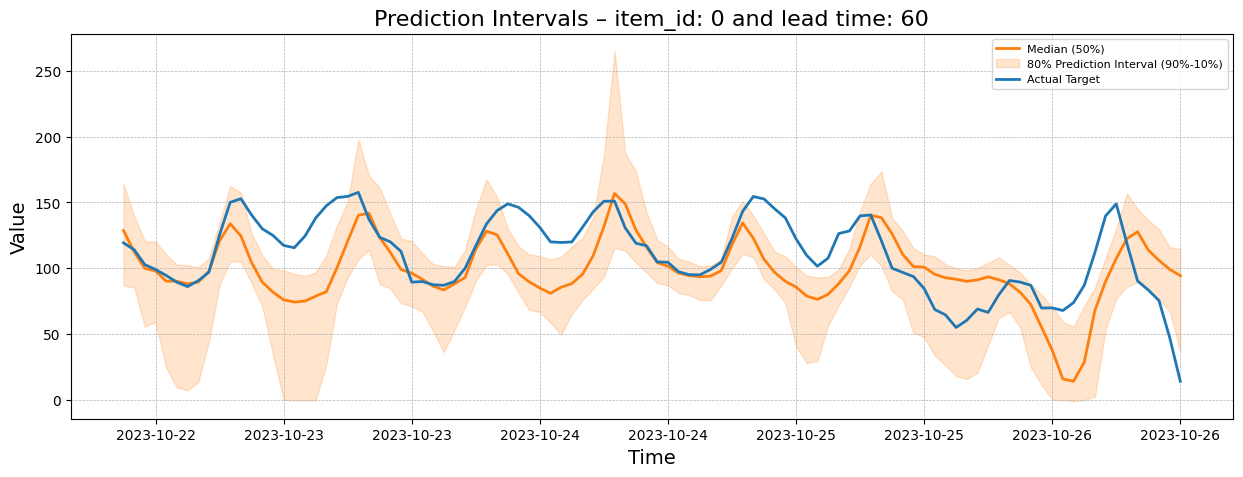

In [51]:
predictions_benchmark_nn.results[60].get_random_plot()

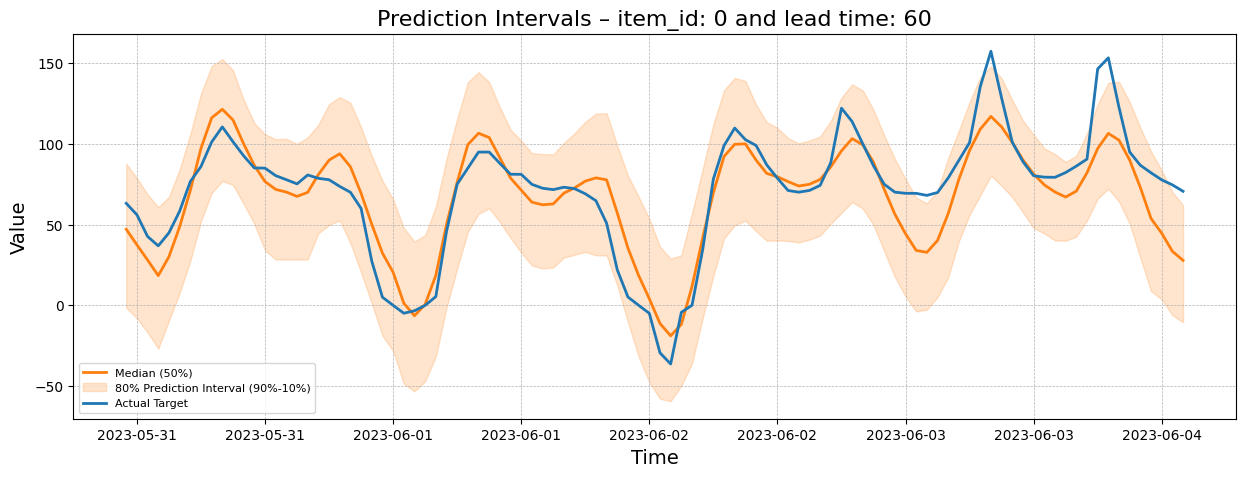

In [57]:
predictions_raw.results[60].get_random_plot()

In [58]:
joblib.dump(predictions_benchmark_nn, "data/predictions/großhandelspreise/predictions_benchmark_nn.joblib")

['data/predictions/großhandelspreise/predictions_benchmark_nn.joblib']

# Postprocessing

### Parametric Approximation of Log-Normal Distribution
- (V1) Fitte Normalverteilung für log Y, mit folgender Parametrisierung: mean = a + b*M, wobei M = Median-Vorhersage des Modells für log Y. Standardabweichung = c + d*IQR, wobei IQR = Interquartilsabstand (z.B. 90%-10%) des Modells für log Y. Falls sich die Modellvorhersagen anfangs auf Y (statt log Y) beziehen kannst Du die einfach logarithmieren, das ist einer der Vorteile von Quantilen.

In [77]:
from src.postprocessors.mle import PostprocessorMLE

In [86]:
postprocessor_mle = PostprocessorMLE()
postprocessor_mle.fit(data=predictions_train)
predictions_post_nrml = postprocessor_mle.postprocess(data=predictions_raw)

  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:01<00:00, 42.01it/s]


In [298]:
joblib.dump(predictions_post_nrml, "data/predictions/predictions_post_nrml.joblib")

['data/predictions/predictions_post_nrml.joblib']

### Quantile Regression

-  (V2) Fitte separate Quantilsregression für jedes Quantil (z.B. 10%, 20%, ..., 90%). D.h. für jedes Level eine Quantilsregression mit Konstante und einem Regressor (= Quantils-Vorhersage des Modells). Der Spezialfall mit Konstante = 0 und Slope = 1 würde dann heißen, dass die Vorhersagen bereits perfekt kalibriert sind.



In [296]:
from src.postprocessors.qr import PostprocessorQR

In [297]:
postprocessor_qr = PostprocessorQR()
postprocessor_qr.fit(data=predictions_train)
predictions_post_qr = postprocessor_qr.postprocess(data=predictions_raw)

100%|██████████| 64/64 [00:03<00:00, 19.59it/s]


In [299]:
joblib.dump(predictions_post_qr, "data/predictions/predictions_post_qr.joblib")

['data/predictions/predictions_post_qr.joblib']

# Evaluation

In [9]:
from src.core.timeseries import get_quantile_scores, get_crps_scores, get_empirical_coverage_rates, get_crps_by_period, plot_crps, PredictionLeadTimes

In [10]:
predictions_raw: PredictionLeadTimes = joblib.load("data/predictions/predictions_raw.joblib")
predictions_post_qr: PredictionLeadTimes = joblib.load("data/predictions/predictions_post_qr.joblib")
predictions_post_nrml: PredictionLeadTimes = joblib.load("data/predictions/predictions_post_nrml.joblib")
predictions_benchmark_nn: PredictionLeadTimes = joblib.load("data/predictions/predictions_benchmark_nn.joblib")
predictions_benchmark_qr: PredictionLeadTimes = joblib.load("data/predictions/predictions_benchmark_qr.joblib")

In [127]:
all_predictions = {"chronos bolt tiny zero shot": predictions_raw, 
                   "postprocessed (QR)": predictions_post_qr,
                   "postprocessed (MLE)": predictions_post_nrml,
                   "benchmark (NN)": predictions_benchmark_nn,
                   "benchmark (QR)": predictions_benchmark_qr
                   }

In [56]:
predictions_raw.get_quantile_scores()

,1,2,3,4,5,6,7,8,9,10,...,56,57,58,59,60,61,62,63,64,QS averaged over all lead times
quantile,,,,,,,,,,,,,,,,,,,,,
0.1,281.06,405.24,521.20,623.10,705.99,773.43,830.06,876.73,915.18,946.28,...,1358.03,1361.31,1364.87,1364.98,1366.29,1368.41,1370.86,1373.69,1376.24,1165.07
0.2,417.00,616.57,794.46,946.27,1068.45,1166.56,1249.50,1320.86,1377.25,1427.14,...,2087.08,2094.45,2101.49,2101.13,2104.79,2107.41,2113.06,2116.93,2121.92,1779.49
0.3,504.72,747.97,959.85,1139.67,1285.59,1403.73,1505.23,1590.11,1661.91,1727.16,...,2537.97,2547.36,2556.15,2556.60,2562.24,2564.19,2571.28,2577.03,2584.93,2160.19
0.4,554.18,817.36,1046.53,1239.65,1397.90,1527.59,1640.41,1732.80,1812.92,1886.74,...,2770.38,2781.10,2789.88,2791.64,2796.71,2798.74,2807.55,2814.97,2826.18,2361.05
0.5,570.34,834.43,1066.11,1261.05,1422.11,1556.82,1672.02,1765.80,1849.00,1924.80,...,2810.00,2821.14,2831.22,2832.69,2838.43,2841.35,2850.89,2858.54,2869.26,2404.28
0.6,555.01,802.43,1021.89,1209.08,1364.01,1493.67,1606.07,1694.27,1774.61,1848.75,...,2674.19,2686.41,2695.49,2698.04,2705.24,2708.24,2717.73,2725.19,2734.61,2299.43
0.7,507.44,720.76,916.05,1083.43,1223.91,1339.21,1439.29,1517.77,1590.63,1658.23,...,2362.56,2373.44,2380.37,2385.55,2391.67,2394.24,2402.87,2409.73,2418.28,2042.51
0.8,420.07,584.63,739.30,874.65,988.63,1082.08,1161.16,1224.55,1283.06,1337.47,...,1863.05,1873.13,1879.64,1883.93,1887.66,1887.56,1893.47,1898.84,1907.49,1619.24
0.9,282.92,376.24,470.85,555.15,629.25,689.83,740.19,779.73,814.09,846.23,...,1131.39,1136.89,1140.03,1144.21,1147.77,1149.25,1151.89,1155.57,1162.08,994.31


In [50]:
pd.concat(predictions_raw.get_quantile_scores(mean_lead_times=False), axis=1)

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
,Mean QS,Mean QS,Mean QS,Mean QS,Mean QS,Mean QS,Mean QS,Mean QS,Mean QS,Mean QS,...,Mean QS,Mean QS,Mean QS,Mean QS,Mean QS,Mean QS,Mean QS,Mean QS,Mean QS,Mean QS
quantile,,,,,,,,,,,,,,,,,,,,,
0.1,281.060972,405.241094,521.200298,623.097229,705.989802,773.433303,830.057847,876.726448,915.178198,946.275261,...,1355.599235,1358.033149,1361.310671,1364.869401,1364.976343,1366.289778,1368.414119,1370.860462,1373.694840,1376.244486
0.2,417.002945,616.569017,794.459596,946.273168,1068.452776,1166.564716,1249.495953,1320.860359,1377.251560,1427.142644,...,2082.783342,2087.081434,2094.452966,2101.488041,2101.127671,2104.788683,2107.413051,2113.059841,2116.929462,2121.916811
0.3,504.721521,747.972625,959.848364,1139.666422,1285.590981,1403.732014,1505.234532,1590.114058,1661.909967,1727.162249,...,2533.101533,2537.973986,2547.361448,2556.145301,2556.596726,2562.238595,2564.187727,2571.280174,2577.028069,2584.928048
0.4,554.179324,817.362622,1046.533474,1239.645940,1397.898445,1527.589636,1640.408880,1732.797336,1812.920779,1886.737395,...,2763.748394,2770.377065,2781.099561,2789.880260,2791.637021,2796.706823,2798.741994,2807.553240,2814.970200,2826.179187
0.5,570.341464,834.431603,1066.114887,1261.045926,1422.112799,1556.822223,1672.023785,1765.800875,1848.999535,1924.804213,...,2803.231442,2810.001219,2821.136574,2831.218115,2832.692369,2838.434351,2841.349890,2850.894159,2858.537536,2869.263046
0.6,555.008821,802.425620,1021.888978,1209.083093,1364.007401,1493.672456,1606.067367,1694.268469,1774.609244,1848.746087,...,2665.988519,2674.191133,2686.405945,2695.491460,2698.040174,2705.236735,2708.239399,2717.734744,2725.193296,2734.613818
0.7,507.439702,720.764350,916.053838,1083.427213,1223.913504,1339.205507,1439.293258,1517.770745,1590.625313,1658.225544,...,2351.392096,2362.564060,2373.444006,2380.372935,2385.547226,2391.674921,2394.235419,2402.867667,2409.731712,2418.276578
0.8,420.066645,584.625050,739.301987,874.646944,988.632439,1082.079240,1161.161098,1224.550056,1283.060604,1337.470440,...,1852.906829,1863.047113,1873.127456,1879.640272,1883.925856,1887.658608,1887.560692,1893.472405,1898.838652,1907.490029


In [17]:
d = pd.DataFrame(predictions_raw.results[1].get_quantile_score(), columns=["Mean QS"])
d.index.name = "quantile"

In [128]:
# averaged score across all time series
get_quantile_scores(all_predictions, lead_times=None, item_ids=None)

,chronos bolt tiny zero shot,postprocessed (QR),postprocessed (MLE),benchmark (NN),benchmark (QR)
quantile,,,,,
0.1,1165.07,1134.60,1153.59,1573.64,1945.51
0.2,1779.49,1758.05,1772.66,2427.13,3013.16
0.3,2160.19,2146.13,2153.84,3012.77,3676.65
0.4,2361.05,2350.22,2351.71,3357.32,4013.57
0.5,2404.28,2392.23,2390.57,3469.73,4063.59
0.6,2299.43,2283.53,2282.11,3369.84,3857.19
0.7,2042.51,2021.53,2026.08,3045.25,3389.15
0.8,1619.24,1593.31,1606.76,2465.55,2640.63
0.9,994.31,971.79,995.69,1566.64,1568.04


In [559]:
# get scores for individual time series
get_quantile_scores(all_predictions, item_ids=[0])

,chronos bolt tiny zero shot,postprocessed (QR),postprocessed (MLE),benchmark (NN),benchmark (QR)
quantile,,,,,
0.1,499.05,496.69,508.72,885.11,1159.46
0.2,685.29,683.49,706.21,1312.98,1780.01
0.3,793.26,788.93,808.78,1654.14,2164.64
0.4,844.66,837.45,848.18,1889.58,2368.78
0.5,848.06,839.16,841.58,1991.69,2412.36
0.6,805.99,796.42,797.40,1963.36,2305.36
0.7,717.04,707.52,714.33,1798.81,2046.51
0.8,573.01,565.47,581.40,1474.84,1620.42
0.9,360.66,357.64,377.58,950.83,992.17


In [ ]:
# get scores for individual time series
get_quantile_scores(all_predictions, item_ids=[0])

,chronos bolt tiny zero shot,postprocessed (QR),postprocessed (MLE),benchmark (NN),benchmark (QR)
quantile,,,,,
0.1,499.05,496.69,508.72,885.11,1159.46
0.2,685.29,683.49,706.21,1312.98,1780.01
0.3,793.26,788.93,808.78,1654.14,2164.64
0.4,844.66,837.45,848.18,1889.58,2368.78
0.5,848.06,839.16,841.58,1991.69,2412.36
0.6,805.99,796.42,797.40,1963.36,2305.36
0.7,717.04,707.52,714.33,1798.81,2046.51
0.8,573.01,565.47,581.40,1474.84,1620.42
0.9,360.66,357.64,377.58,950.83,992.17


In [ ]:
# averaged score across all time series
get_quantile_scores(all_predictions, item_ids=None)

,chronos bolt tiny zero shot,postprocessed (QR),postprocessed (MLE),benchmark (NN),benchmark (QR)
quantile,,,,,
0.1,1165.07,1134.60,1151.46,1573.64,1945.51
0.2,1779.49,1758.05,1773.25,2427.13,3013.16
0.3,2160.19,2146.13,2155.12,3012.77,3676.65
0.4,2361.05,2350.22,2352.31,3357.32,4013.57
0.5,2404.28,2392.23,2390.16,3469.73,4063.59
0.6,2299.43,2283.53,2281.13,3369.84,3857.19
0.7,2042.51,2021.53,2024.79,3045.25,3389.15
0.8,1619.24,1593.31,1605.20,2465.55,2640.63
0.9,994.31,971.79,991.78,1566.64,1568.04


In [ ]:
# get scores for individual time series
get_empirical_coverage_rates(all_predictions, item_ids=[0])

,chronos bolt tiny zero shot,postprocessed (QR),postprocessed (MLE),benchmark (NN),benchmark (QR)
quantile,,,,,
0.1,0.08,0.09,0.07,0.16,0.28
0.2,0.17,0.18,0.14,0.29,0.46
0.3,0.26,0.28,0.23,0.39,0.59
0.4,0.36,0.39,0.35,0.47,0.70
0.5,0.46,0.50,0.48,0.52,0.78
0.6,0.56,0.60,0.61,0.58,0.85
0.7,0.66,0.71,0.74,0.63,0.91
0.8,0.78,0.81,0.85,0.70,0.96
0.9,0.90,0.91,0.94,0.76,0.99


In [ ]:
# get scores for individual time series
get_empirical_coverage_rates(all_predictions, item_ids=[1])

,chronos bolt tiny zero shot,postprocessed (QR),postprocessed (MLE),benchmark (NN),benchmark (QR)
quantile,,,,,
0.1,0.13,0.11,0.13,0.15,0.23
0.2,0.24,0.22,0.23,0.24,0.36
0.3,0.33,0.33,0.32,0.32,0.48
0.4,0.42,0.43,0.41,0.41,0.59
0.5,0.51,0.52,0.50,0.49,0.68
0.6,0.60,0.61,0.59,0.58,0.77
0.7,0.69,0.70,0.69,0.67,0.85
0.8,0.79,0.80,0.80,0.75,0.91
0.9,0.89,0.90,0.91,0.83,0.97


In [129]:
get_crps_scores(all_predictions)

,chronos bolt tiny zero shot,postprocessed (QR),postprocessed (MLE),benchmark (NN),benchmark (QR)
lead times,,,,,
1,909.50,844.21,840.21,5399.69,6398.99
2,1312.36,1283.86,1283.12,5399.49,6366.85
3,1674.72,1650.89,1652.44,5399.33,6319.89
4,1984.90,1958.76,1961.26,5399.14,6261.72
5,2241.30,2213.30,2215.97,5398.92,6204.97
...,...,...,...,...,...
60,4400.18,4368.60,4392.10,5398.18,6359.98
61,4404.31,4373.74,4395.93,5398.14,6354.32
62,4417.69,4388.50,4410.56,5398.16,6321.55


In [62]:
get_crps_by_period(all_predictions, date_splits=[pd.Timestamp("01-01-2024"), pd.Timestamp("01-01-2025")], item_ids=[0])

,chronos bolt tiny zero shot,postprocessed (QR),postprocessed (MLE),benchmark (NN)
2023-01-01 00:00:00_to_2024-01-01 00:00:00,1328.860614,1317.077104,1341.918826,3020.954506
2024-01-01 00:00:00_to_2025-01-01 00:00:00,1419.924354,1405.274336,1425.747340,3171.027140
2025-01-01 00:00:00_to_2025-03-26 23:00:00,1245.846360,1244.409036,1286.930787,3077.875519


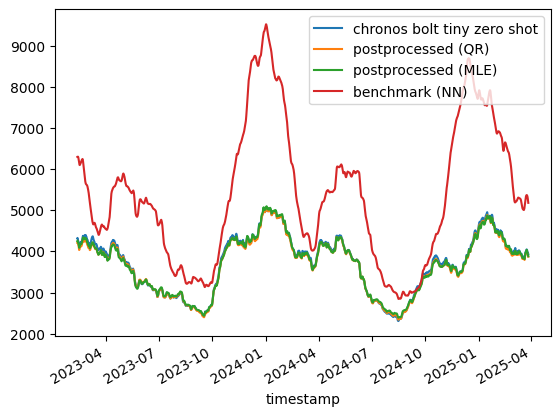

In [735]:
plot_crps(all_predictions, rolling_window=1000)

### Evaluation for individual model prediction (more details)

In [307]:
predictions_raw.get_crps(lead_times=[1, 12, 24, 32, 48, 64], mean=True)

{'Mean CRPS Score': 3436.78}

In [308]:
predictions_raw.get_quantile_scores(lead_times=[1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64,QS averaged over all lead times
quantile,,,,,,,
0.1,281.06,999.10,1165.42,1273.94,1318.51,1376.24,1069.05
0.2,417.00,1510.41,1755.92,1951.83,2026.06,2121.92,1630.52
0.3,504.72,1829.20,2120.95,2374.42,2467.57,2584.93,1980.30
0.4,554.18,2000.92,2321.34,2603.57,2694.53,2826.18,2166.79
0.5,570.34,2045.00,2375.78,2655.95,2735.84,2869.26,2208.70
0.6,555.01,1967.60,2285.49,2537.47,2605.72,2734.61,2114.32
0.7,507.44,1765.87,2041.51,2247.49,2301.64,2418.28,1880.37
0.8,420.07,1424.42,1629.40,1773.75,1808.86,1907.49,1494.00
0.9,282.92,902.00,1007.73,1076.28,1097.99,1162.08,921.50


In [309]:
predictions_raw.get_empirical_coverage_rates(lead_times=[1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64,Empirical coverage rates averaged over all lead times
quantile,,,,,,,
0.1,0.04,0.12,0.11,0.11,0.11,0.11,0.10
0.2,0.14,0.22,0.21,0.20,0.21,0.20,0.20
0.3,0.26,0.31,0.31,0.29,0.30,0.29,0.29
0.4,0.39,0.40,0.41,0.38,0.39,0.38,0.39
0.5,0.52,0.49,0.49,0.47,0.49,0.47,0.49
0.6,0.65,0.58,0.59,0.56,0.58,0.57,0.59
0.7,0.77,0.67,0.68,0.65,0.68,0.67,0.69
0.8,0.88,0.78,0.78,0.76,0.78,0.78,0.79
0.9,0.96,0.89,0.90,0.88,0.90,0.90,0.90


<Figure size 800x800 with 0 Axes>

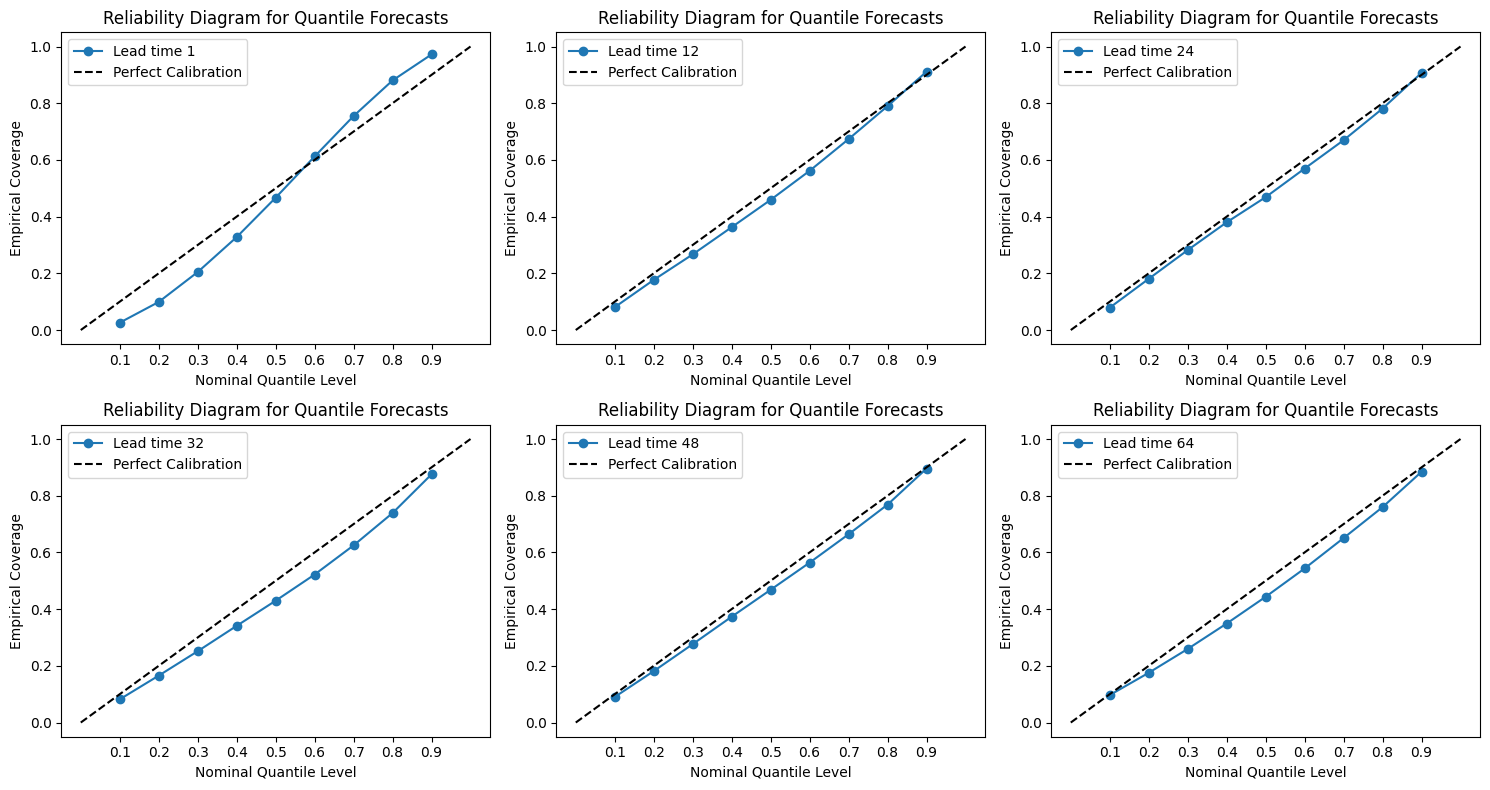

In [165]:
predictions_raw.get_reliability_diagram(lead_times=[1, 12, 24, 32, 48, 64], item_ids=[0])

<Figure size 800x800 with 0 Axes>

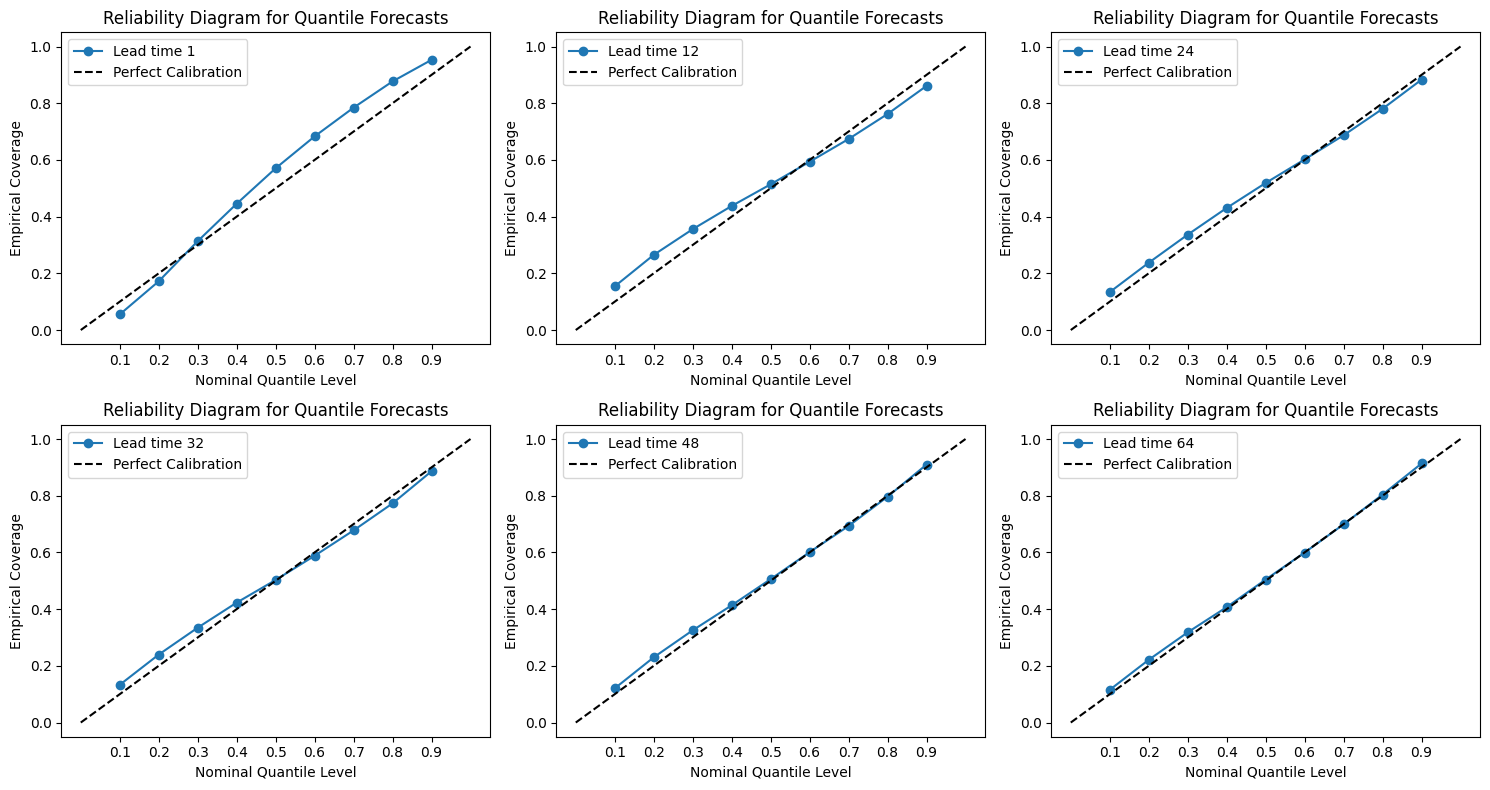

In [164]:
predictions_raw.get_reliability_diagram(lead_times=[1, 12, 24, 32, 48, 64], item_ids=[1])

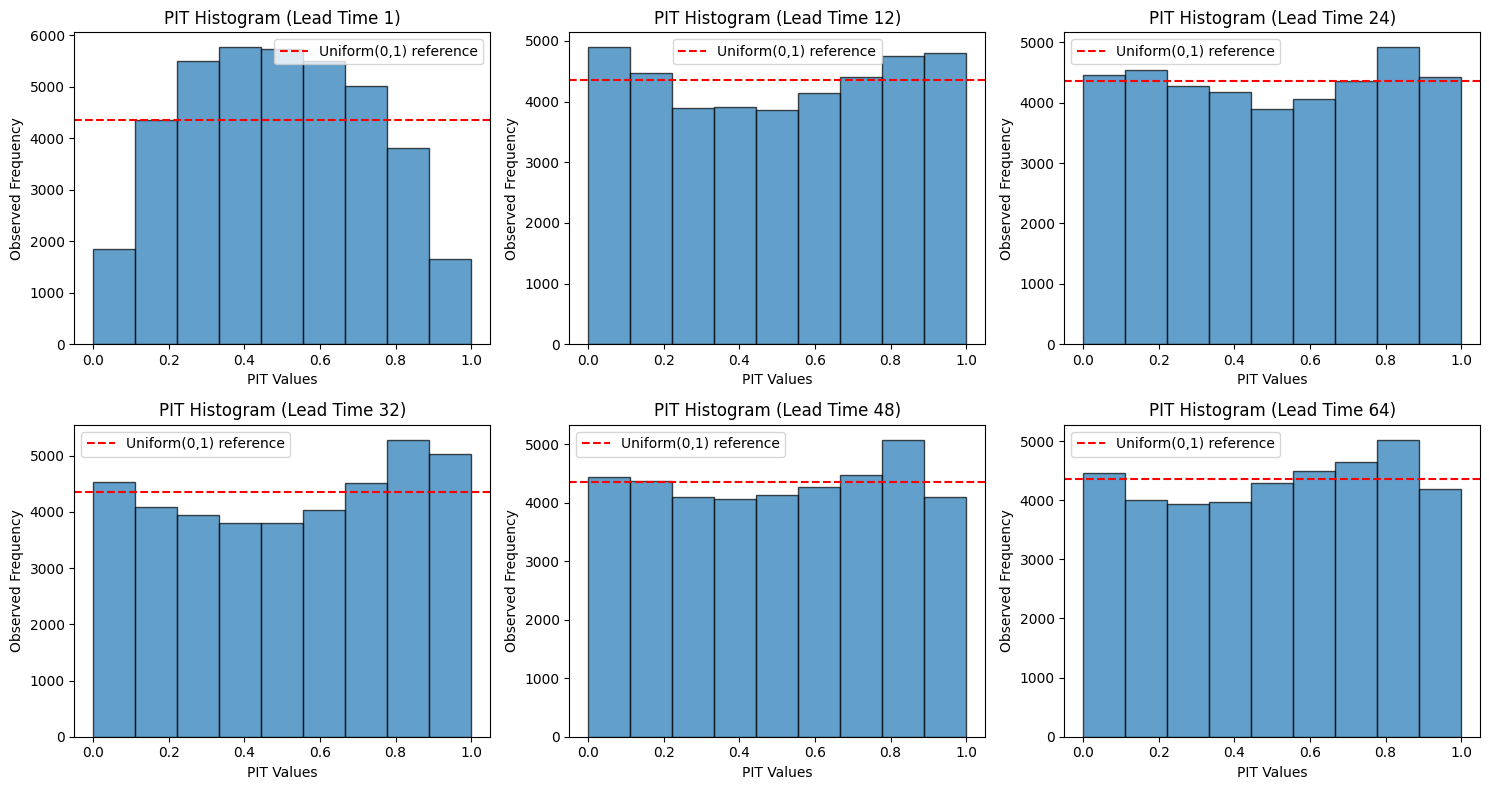

In [166]:
predictions_raw.get_pit_histogram(lead_times=[1, 12, 24, 32, 48, 64])

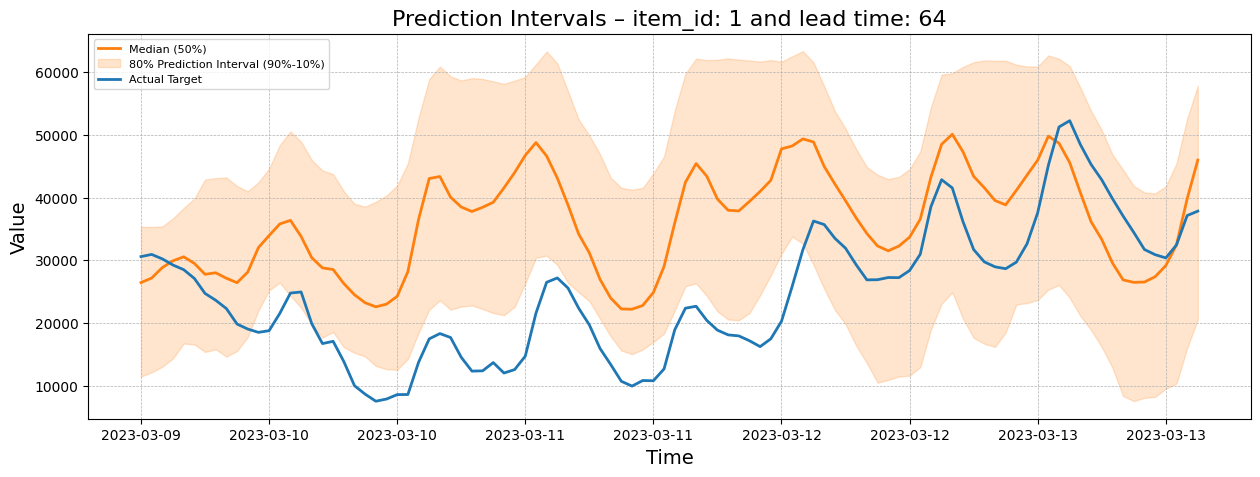

In [122]:
predictions_benchmark_nn.results[64].get_random_plot(item_id=1)